# fashion mnist


In [4]:
import sys
import os
import random
import pickle
from tqdm.notebook import tqdm
from os.path import join

import struct
from array import array

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Add the /root/src directory to sys.path
sys.path.append(os.path.abspath("../src"))
from utils.data_extraction import MNISTDataReader  # Replace with actual function name




In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# set seed for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda


## Loading in MNIST data

In [22]:
# # needed to download the data initially
# torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
# torchvision.datasets.CIFAR10(root='../data', train=False, download=True)

# reading in data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

x_train = []
y_train = []
for i in range(1,6):
    batch = unpickle(f'../data/cifar-10-batches-py/data_batch_{i}')
    x_train.append(batch["data"])
    y_train.append(batch["labels"])
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

test = unpickle('../data/cifar-10-batches-py/test_batch')
x_test = test["data"]
y_test = np.array(test["labels"])

# basic exploratory analysis

In [28]:
metadata = unpickle("../data/cifar-10-batches-py/batches.meta")
metadata["label_names"]

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

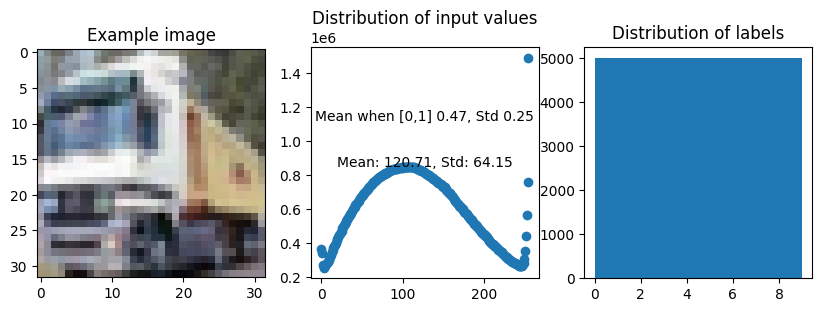

In [39]:
# basic exploratory analysis
def row_to_image(row):
    return row.reshape(3,32,32).transpose(1,2,0)

fig = plt.figure(figsize=(10, 3))

# plot example image
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Example image")
ax1.imshow(row_to_image(x_train[1]));

# plot distribtuion of input values
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Distribution of input values")
ax2.scatter(*np.unique(x_train, return_counts=True));
ax2.text(0.5, 0.5, f"Mean: {x_train.mean():.2f}, Std: {x_train.std():.2f}",
         ha='center', va='center', transform=ax2.transAxes)
ax2.text(0.5, 0.7, f"Mean when [0,1] {x_train.mean()/255:.2f}, Std {x_train.std()/255:.2f}",
         ha='center', va='center', transform=ax2.transAxes)

#plot distribution of labels
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Distribution of labels")
ax3.hist(y_train);

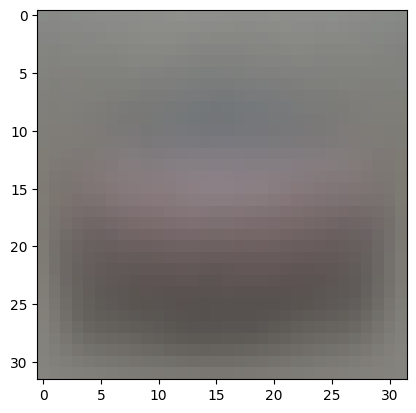

In [69]:
plt.imshow(row_to_image(x_train[y_train == 1].mean(axis=0)/255))

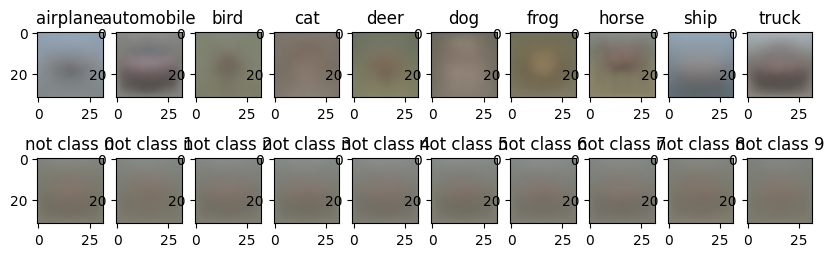

In [76]:
#visualize each class
fig = plt.figure(figsize = (10,3))

for i in range(0,10):
    ax1 = fig.add_subplot(2,10,i+1)
    ax1.imshow(row_to_image(x_train[y_train == i].mean(axis=0))/255)
    ax1.set_title(f"{metadata['label_names'][i]}")
    ax2 = fig.add_subplot(2,10,i+11)
    ax2.imshow(row_to_image(x_train[y_train != i].mean(axis=0))/255)
    ax2.set_title(f"not class {i}")
    # ax3 = fig.add_subplot(3,10,i+21)
    # ax3.imshow(row_to_image((x_train[y_train == i].mean(axis=0)) - (x_train[y_train != i].mean(axis=0)))/255)
    # ax3.set_title(f"class {i} - not {i}")

# creating dataset and loaders 

tensor([[[[ 59,  43,  50,  ..., 158, 152, 148],
          [ 16,   0,  18,  ..., 123, 119, 122],
          [ 25,  16,  49,  ..., 118, 120, 109],
          ...,
          [208, 201, 198,  ..., 160,  56,  53],
          [180, 173, 186,  ..., 184,  97,  83],
          [177, 168, 179,  ..., 216, 151, 123]],

         [[ 62,  46,  48,  ..., 132, 125, 124],
          [ 20,   0,   8,  ...,  88,  83,  87],
          [ 24,   7,  27,  ...,  84,  84,  73],
          ...,
          [170, 153, 161,  ..., 133,  31,  34],
          [139, 123, 144,  ..., 148,  62,  53],
          [144, 129, 142,  ..., 184, 118,  92]],

         [[ 63,  45,  43,  ..., 108, 102, 103],
          [ 20,   0,   0,  ...,  55,  50,  57],
          [ 21,   0,   8,  ...,  50,  50,  42],
          ...,
          [ 96,  34,  26,  ...,  70,   7,  20],
          [ 96,  42,  30,  ...,  94,  34,  34],
          [116,  94,  87,  ..., 140,  84,  72]]],


        [[[154, 126, 105,  ...,  91,  87,  79],
          [140, 145, 125,  ...,  96

In [87]:
x_train[0].shape

(3072,)

In [88]:
## define datasets 
class ImageDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data).reshape(-1,3,32,32)
        self.y_data = torch.tensor(y_data)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # Convert numpy arrays to torch tensors
        x = self.x_data[idx] #dont want to squeeze here as we want to keep the [CxHxW] even if one 1 channel
        y = self.y_data[idx]
        return x, y


class FlatDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data)
        self.y_data = torch.tensor(y_data)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx].view(1,-1).squeeze()
        y = self.y_data[idx]
        return x, y


# Create datset and dataloader
image_train_dataset = ImageDataset(x_train, y_train)
image_train_dataloader = DataLoader(image_train_dataset, batch_size=32, shuffle=True)
image_test_dataset = ImageDataset(x_test, y_test)
image_test_dataloader = DataLoader(image_test_dataset, batch_size=32, shuffle=False)

flat_train_dataset = FlatDataset(x_train, y_train)
flat_train_dataloader = DataLoader(flat_train_dataset, batch_size=32, shuffle=True)
flat_test_dataset = FlatDataset(x_test, y_test)
flat_test_dataloader = DataLoader(flat_test_dataset, batch_size=32, shuffle=False)


Define the models - 
1. Logistic regression
2. FCNN
3. very basic CNN
4. CNN based on efficient net paper

# Metric definition

In [89]:
def classification_metrics(predictions,labels):
    outputs = {
        "Accuracy":(predictions == labels).mean()
    }
    print(outputs)
    return outputs

# logistic regression baseline

In [90]:
# simple logistic regression model
logregmodel = LogisticRegression(max_iter=1000)
logregmodel.fit(x_train, y_train)

KeyboardInterrupt: 

In [68]:
x_test_flat = x_test.reshape(x_test.shape[0],-1)
classification_metrics(logregmodel.predict(x_test_flat),y_test)

{'Accuracy': 0.8333}


{'Accuracy': 0.8333}

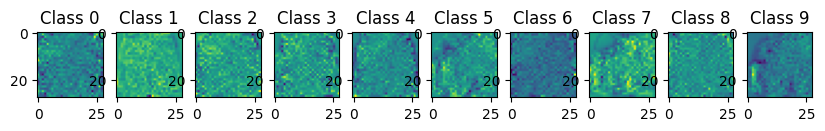

In [69]:
fig = plt.figure(figsize=(10,3))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(logregmodel.coef_[i].reshape(28,28))
    ax.set_title(f"Class {i}")

# Deep learning models

In [20]:
def train_one_epoch(model=None, 
                    optimizer=None, 
                    loss_fn=None, 
                    dataloader=None, 
                    verbose=False) -> tuple:
    '''
    1 epoch cycle of training for a general nn model
    '''
    train_loss = []
    dataloader_ = tqdm(dataloader,leave=False) if verbose else dataloader
    for batch_x, batch_y in dataloader_:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) # move intputs to GPU

        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    if verbose: dataloader_.close()
    
    # validation loop
    with torch.no_grad():
        val_loss = []
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device) # move intputs to GPU
            
            output = model(batch_x)
            loss = loss_fn(output, batch_y)

            val_loss.append(loss.item())

    return train_loss, val_loss

# Multilayer Perceptron

In [11]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.fc1(x) 
        return x

In [29]:
mlp_model = MLP().to(device)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in tqdm(range(30)):
    # training loop
    train_loss, val_loss = train_one_epoch(model = mlp_model,
                                           optimizer = optimizer,
                                           loss_fn = loss_fn,
                                           dataloader = flat_train_dataloader,
                                           verbose = False)

    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    tqdm.write(f"Epoch {epoch} train_loss: {np.mean(train_loss):.4} val_loss: {np.mean(val_loss):.4}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 train_loss: 0.593 val_loss: 0.4744
Epoch 1 train_loss: 0.4598 val_loss: 0.4356
Epoch 2 train_loss: 0.4343 val_loss: 0.415
Epoch 3 train_loss: 0.4207 val_loss: 0.4112
Epoch 4 train_loss: 0.412 val_loss: 0.3996
Epoch 5 train_loss: 0.4064 val_loss: 0.3923
Epoch 6 train_loss: 0.4018 val_loss: 0.3935
Epoch 7 train_loss: 0.3962 val_loss: 0.3969
Epoch 8 train_loss: 0.3937 val_loss: 0.3809
Epoch 9 train_loss: 0.3918 val_loss: 0.3824
Epoch 10 train_loss: 0.3897 val_loss: 0.3857
Epoch 11 train_loss: 0.3884 val_loss: 0.3791
Epoch 12 train_loss: 0.3863 val_loss: 0.3749
Epoch 13 train_loss: 0.3832 val_loss: 0.382
Epoch 14 train_loss: 0.382 val_loss: 0.3718
Epoch 15 train_loss: 0.3815 val_loss: 0.3695
Epoch 16 train_loss: 0.3795 val_loss: 0.3785
Epoch 17 train_loss: 0.3789 val_loss: 0.3672
Epoch 18 train_loss: 0.3764 val_loss: 0.3821
Epoch 19 train_loss: 0.3752 val_loss: 0.368
Epoch 20 train_loss: 0.3749 val_loss: 0.3655
Epoch 21 train_loss: 0.376 val_loss: 0.3775
Epoch 22 train_loss: 0.3725

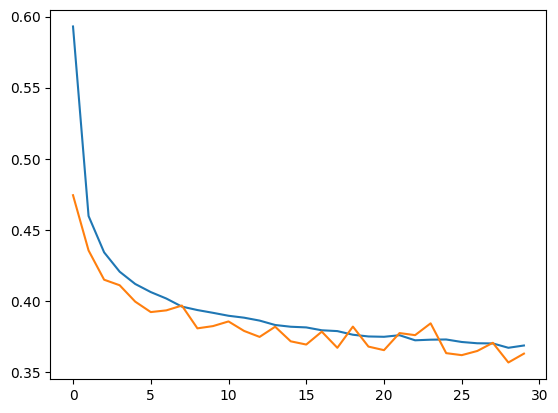

In [30]:
plt.plot(np.array(train_losses).mean(axis = 1))
plt.plot(np.array(val_losses).mean(axis = 1))

In [31]:
def prediction_helper(model,dataloader):
    predictions = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            predictions.append(output.argmax(dim=1).detach().cpu().numpy())
    predictions = np.concatenate(predictions)
    return predictions

def classification_metrics(predictions,labels):
    outputs = {
        "Accuracy":(predictions == labels).mean()
    }
    print(outputs)
    return outputs

predictions = prediction_helper(mlp_model,flat_test_dataloader)
classification_metrics(predictions,y_test);


{'Accuracy': 0.8428}


# Convolutional Neural Networks

## Basic CNN 

In [26]:
#define a basic CNN
class BasicCNN(nn.Module):
    def __init__(self,kernel_size=3,stride=1,padding=1):
        super(BasicCNN, self).__init__()
        # inputs are [1, 28, 28]
        # defaults are kernel_size=3, stride=1, padding=1
        # output is [32, 28+2*padding-kernel_size+1, 28+2*padding-kernel_size+1]
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=stride, padding=padding) # [1, 28, 28] -> [32, 28, 28]
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # [32, 28, 28] -> [32, 14, 14] 
        self.relu = nn.ReLU() # [32, 14, 14] -> [32, 14, 14]
        self.flatten = nn.Flatten() # [32, 14, 14] -> [32*14*14] ([6272])
        self.fc1 = nn.Linear(32*14*14, 10) # [6272] -> [10] #output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [ ]:
basic_cnn_model = BasicCNN().to(device)
basic_cnn_optimizer = optim.Adam(basic_cnn_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(20):
    train_loss, val_loss = train_one_epoch(model = basic_cnn_model,
                                           optimizer = basic_cnn_optimizer,
                                           loss_fn = loss_fn,
                                           dataloader = image_train_dataloader,
                                           verbose = False)

    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    print(f"Epoch {epoch} train_loss: {np.mean(train_loss):.4} val_loss: {np.mean(val_loss):.4}")

Epoch 0 train_loss: 0.4133 val_loss: 0.2967
Epoch 1 train_loss: 0.2918 val_loss: 0.2588
Epoch 2 train_loss: 0.2581 val_loss: 0.2284
Epoch 3 train_loss: 0.2392 val_loss: 0.2103
Epoch 4 train_loss: 0.2211 val_loss: 0.21


In [ ]:
cnn_predictions = prediction_helper(basic_cnn_model,image_test_dataloader)
classification_metrics(predictions,y_test);

{'Accuracy': 0.8448}


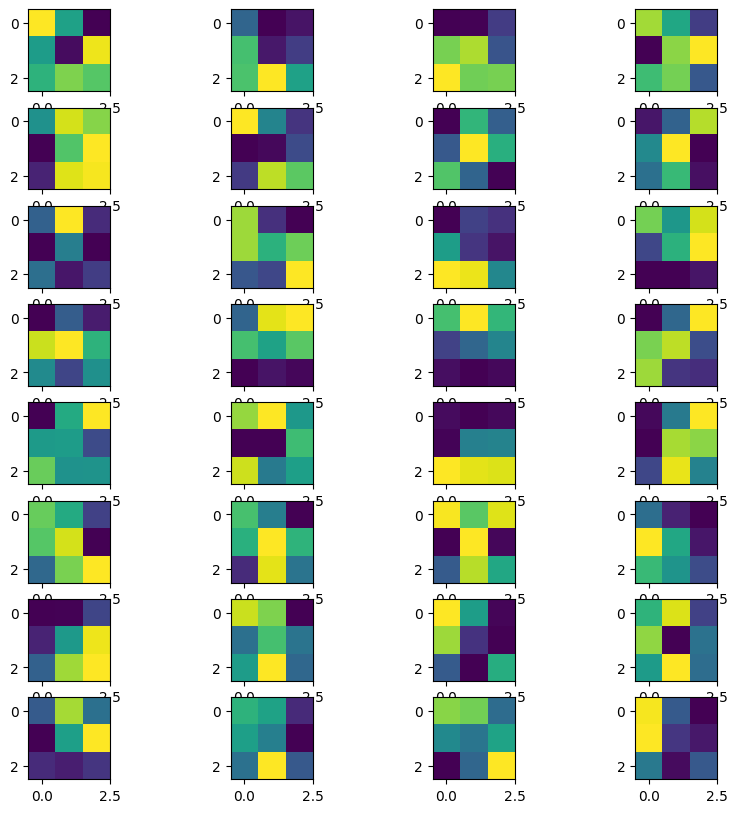

In [299]:

kernels = [i for i in basic_cnn_model.conv1.named_parameters() if i[0] == "weight"][0][1]
kernels = [i.softmax() ] # torch softmax
len(kernels)
fig = plt.figure(figsize = (10,10))
for i,x in enumerate(kernels):
    ax = fig.add_subplot(8,32//8,i+1)
    ax.imshow(x)
